In [1]:
from gurobipy import *
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
# 兩點距離
def dis(x1,x2):
    return math.sqrt(pow(x1[0]-x2[0],2) + pow(x1[1]-x2[1],2))
# 四捨五入用
def simple(num):
    return math.floor(num*100)/100

In [3]:
# 模型graph生成
def init(p, candi, goal):
#     goal = [0,0]
#     map_range = [32,32] #x軸、y軸範圍
#     spacing = 15 #候選點的間距
#     n1 = 5 #羊數量
#     print(candi[0])
#     print(p[0])
    # p = {
    # 0:[5,32],
    # 1: [11,50],
    # 2: [31,9],
    # 3: [5, 2],
    # 4 : [10, 40]
    # }

    # candi = {}

    # count = 0
    # for i in range(0,map_range[0],spacing):
    #     for j in range(0,map_range[1],spacing):
    #         candi[count]=[i,j]
    #         count += 1
    # candi[count] = [3.61, 3.61]
    # count+=1
    # candi[count] = [6.44, 22.66]
    # count+=1
    # candi[count] = [10.02, 20.98]
    # count+=1
    # candi[count] = [14.16, 18.68]
    # count+=1

    A1 = {} #羊到會合點(包含終點)的arc的長度
    for i in p:
        for j in candi:
            A1[i,j] = dis(p[i],candi[j])
        A1[i,len(candi)] = dis(p[i], goal)

    A2 = {} #會合點到會合點的arc的長度
    for i in range(len(candi)):
        for j in range(len(candi)):
            if not i == j : 
                A2[i,j] = dis(candi[i],candi[j])

    A3 = {} #會合點到終點的arc的長度
    for i in candi:
        A3[i] = dis(goal,candi[i])
    return A1, A2, A3

In [4]:
# print(candi)

In [5]:
# 模型1(選部分點ver)
def setup(p, candi, A1, A2, A3, goal):
    model = Model("sheep")
    x1 = {}
    x2 = {}
    x3 = {}
    #y = {}
    z1 = {}
    z2 = {}
    z3 = {}

    #for i in candi :
    #   y[i] = model.addVar(vtype = "B", name = "y(%s)"%i)

    for (i,j) in A1 :
        x1[i,j] = model.addVar(vtype = "I", name = "x1(%s,%s)"%(i,j))
        z1[i,j] = model.addVar(vtype = "B", name = "z1(%s,%s)"%(i,j))
    # for i in p:
    #     x1[i,0] = model.addVar(vtype = "I", name = 'x1{},{}'.format(i,j))
    #     z1[i,0] = model.addVar(vtype = "B", name = 'z1{},{}'.format(i,j))
    for (i,j) in A2 :
        x2[i,j] = model.addVar(vtype = "I", name = "x2(%s,%s)"%(i,j))
        z2[i,j] = model.addVar(vtype = "B", name = "z2(%s,%s)"%(i,j))
    for j in A3 :
        x3[j] = model.addVar(vtype = "I", name = "x3(%s)"%j)
        z3[j] = model.addVar(vtype = "B", name = "z3(%s)"%j)

    n2 = model.addVar(vtype = "I", name = "n2")

    model.update()
    for i in p:
        model.addConstr(quicksum(x1[i,j] for j in candi) == 1 )

    for j in range(len(candi)):
        model.addConstr(quicksum(x1[i,j] for i in p) + quicksum(x2[i,j] for i in range(len(candi)) if not i == j) - quicksum(x2[j,i] for i in range(len(candi)) if not i == j) - x3[j]  == 0 )
#         model.addConstr(quicksum(x2[j,i] for i in range(len(candi)) if not i == j) == 1)
    model.addConstr(quicksum(x3[j] for j in A3) + quicksum(x1[i,0] for i in p) == len(p) )

    for (i,j) in A1 :
        model.addConstr(x1[i,j] <=  n2*z1[i,j])
    for (i,j) in A2 :
        model.addConstr(x2[i,j] <=  n2*z2[i,j])
    for j in A3 :
        model.addConstr(x3[j] <= n2*z3[j])
    
    # objective
    model.setObjective(quicksum(A1[i,j]*z1[i,j] for (i,j) in z1) + quicksum(A2[i,j]*z2[i,j] for (i,j) in A2) + quicksum(A3[j]*z3[j] for (j) in A3),GRB.MINIMIZE)
    return model

In [6]:
# 模型2(選全部點ver)
def setupIP(p, candi, A1, A2, A3, goal):
    model = Model("sheep")
    x1 = {}
    x2 = {}
    x3 = {}
    #y = {}
    z1 = {}
    z2 = {}
    z3 = {}

    #for i in candi :
    #   y[i] = model.addVar(vtype = "B", name = "y(%s)"%i)

    for (i,j) in A1 :
        x1[i,j] = model.addVar(vtype = "I", name = "x1(%s,%s)"%(i,j))
        z1[i,j] = model.addVar(vtype = "B", name = "z1(%s,%s)"%(i,j))
#     for i in p:
#         x1[i,0] = model.addVar(vtype = "I", name = 'x1{},{}'.format(i,j))
    #     z1[i,0] = model.addVar(vtype = "B", name = 'z1{},{}'.format(i,j))
    for (i,j) in A2 :
        x2[i,j] = model.addVar(vtype = "I", name = "x2(%s,%s)"%(i,j))
        z2[i,j] = model.addVar(vtype = "B", name = "z2(%s,%s)"%(i,j))
    for j in A3 :
        x3[j] = model.addVar(vtype = "I", name = "x3(%s)"%j)
        z3[j] = model.addVar(vtype = "B", name = "z3(%s)"%j)

    n2 = model.addVar(vtype = "I", name = "n2")

    model.update()
    for i in p:
        model.addConstr(quicksum(x1[i,j] for j in candi) == 1 )

    for j in range(len(candi)):
        model.addConstr(quicksum(x1[i,j] for i in p) + quicksum(x2[i,j] for i in range(len(candi)) if not i == j) - quicksum(x2[j,i] for i in range(len(candi)) if not i == j) - x3[j]  == 0 )
        model.addConstr(quicksum(x2[j,i] for i in range(len(candi)) if not i == j) + x3[j] >= 1)
    model.addConstr(quicksum(x3[j] for j in A3) + quicksum(x1[i,0] for i in p) == len(p) )

    for (i,j) in A1 :
        model.addConstr(x1[i,j] <=  len(p)*z1[i,j])
    for (i,j) in A2 :
        model.addConstr(x2[i,j] <=  len(p)*z2[i,j])
    for j in A3 :
        model.addConstr(x3[j] <= len(p)*z3[j])
    
    # objective
    model.setObjective(quicksum(A1[i,j]*z1[i,j] for (i,j) in z1) + quicksum(A2[i,j]*z2[i,j] for (i,j) in A2) + quicksum(A3[j]*z3[j] for (j) in A3),GRB.MINIMIZE)
    return model

In [7]:
# A1, A2, A3 = init(test_p, bestcase[0], test_goal)
# test_model = setup(test_p, bestcase[0], A1,A2,A3,test_goal)
# test_model.optimize()

In [8]:
# print("Objective value :", test_model.ObjVal)
# for v in test_model.getVars():
#     if("x" in v.VarName):
#         if(v.x > 0):
#             print(v.VarName,v.x)
# print("n2 : ",test_model.getVarByName("n2").x)

In [9]:
# print(candi)

In [10]:
# fig = plt.figure()
# # plt.xlim(-5,map_range[0]+5)
# # plt.ylim(-5,map_range[1]+5)
# candi = bestcase[0]
# goal = test_goal
# p = test_p
# x1 = []
# x2 = []
# x3 = []
# for v in test_model.getVars():
#     if(v.x > 0):
#         if("x1" in v.VarName):
#             x1.append(v.VarName.replace("x1","").replace("(","").replace(")","").split(",")) 
#         if("x2" in v.VarName):
#             x2.append(v.VarName.replace("x2","").replace("(","").replace(")","").split(","))
#         if("x3" in v.VarName):
#             x3.append(v.VarName.replace("x3","").replace("(","").replace(")",""))

# for i in range(len(x3)):
#     plt.plot([candi[int(x3[i])][0],goal[0]],[candi[int(x3[i])][1],goal[1]],'bo-')
# for i in range(len(x2)):
#     plt.plot([candi[int(x2[i][0])][0],candi[int(x2[i][1])][0]],[candi[int(x2[i][0])][1],candi[int(x2[i][1])][1]],'bo-')
# for i in range(len(x1)):
#     plt.plot([p[int(x1[i][0])][0],candi[int(x1[i][1])][0]],[p[int(x1[i][0])][1],candi[int(x1[i][1])][1]],'bo-')
#     plt.plot(p[i][0],p[i][1],'ro')
# plt.plot(goal[0],goal[1],'go')
# plt.axis([0,50,0,60])
# plt.show()

In [11]:
# pso
# readfile
test_p = {}
test_goal = list()
test_n = 0
cognition_factor = 0
social_factor = 0
iterations = 0
pop_size = 0
with open('input_pso.txt', 'r',encoding="utf-8") as f:
    line = f.readline()
    while line:
        line = f.readline()
        if line != '':
            text = line.split('\t', 4)
            if line[0] == 'p':
                test_p[int(text[1])] = [int(text[2]), int(text[3])]
            elif line[0] == 'o':
                test_goal = [int(text[1]), int(text[2])]
            elif line[0] == 'n':
                test_n = int(text[1])
            elif line[0] == 'r':
                cognition_factor = float(text[1])
                social_factor = float(text[2])
            elif line[0] == 't':
                iterations = int(text[1])
            elif line[0] == 'z':
                pop_size = int(text[1])
                

In [12]:
# pso 相關function
def update(curr, objs, best_local, best_global, bestcase_local, bestcase):
    flag = False
    for i in curr:
        if  objs[i] < best_local[i]:
            bestcase_local[i] = copy.deepcopy(curr[i])
            best_local[i] = objs[i]
            # update
            if objs[i] < best_global:
#                 print('change')
                flag = True
                best_global = objs[i]
                bestcase[0] = copy.deepcopy(curr[i])
    return best_global, flag
def movement(curr, cognition_factor, social_factor, bestcase_local, bestcase):
    for i in curr:
        alpha = cognition_factor*random.random()
        beta = social_factor*random.random()
        for j in curr[i]:
            vx = alpha*(bestcase_local[i][j][0] - curr[i][j][0]) + beta*(bestcase[0][j][0] - curr[i][j][0])
            vy = alpha*(bestcase_local[i][j][1] - curr[i][j][1]) + beta*(bestcase[0][j][1] - curr[i][j][1])
            curr[i][j] = [max(simple(vx + curr[i][j][0]),0), max(simple(vy+ curr[i][j][1]),0)]

In [13]:
def init_pso(test_p, test_goal, pop_size):
    # create random candi
    curr = {}
    objs = {}
    best_local = {}
    best_global = 99999
#     pop_size = 3
    for i in range(len(test_p)):
        curr[i] = {}
        objs[i] = 99999
        best_local[i] = 99999
        for j in range(pop_size):
            curr[i][j] = [simple(random.uniform(0, 40)), simple(random.uniform(0, 40))]
    bestcase_local = {}
    bestcase = {}
    A1 = {}
    A2 = {}
    A3 = {}
    for i in range(len(curr)):
        A1, A2, A3 = init(test_p, curr[i], test_goal)
        test_model = setupIP(test_p, curr[i], A1,A2,A3,test_goal)
        test_model.Params.LogToConsole = 0
        test_model.optimize()
        objs[i] = test_model.ObjVal
    best_global, flag = update(curr, objs, best_local, best_global, bestcase_local, bestcase)
    return curr, objs, best_local, best_global, bestcase_local, bestcase


In [14]:
def pso(iterations, curr, cognition_factor, social_factor, best_local, best_global, bestcase_local, bestcase, test_p, test_goal):
#     iterations = 100
    for x in range(iterations):
        movement(curr, cognition_factor, social_factor, bestcase_local, bestcase)
        for i in range(len(curr)):
            A1 = {}
            A2 = {}
            A3 = {}
            A1, A2, A3 = init(test_p, curr[i], test_goal)
    #         print(curr)
            test_model = setupIP(test_p, curr[i], A1,A2,A3,test_goal)
            test_model.Params.LogToConsole = 0
            test_model.optimize()
            objs[i] = test_model.ObjVal
    #     print(curr)
        best_global, flag = update(curr, objs, best_local, best_global, bestcase_local, bestcase)
#         if flag:
#             print('iteration ' + str(x) + ' , best_global: ' + str(best_global))
    return best_global

# best_global = pso(100, curr, cognition_factor, social_factor, best_local, best_global, bestcase_local, bestcase, test_p, test_goal)    
# print('done, totalBest:' + str(best_global))
# # for i in bestcase[0]:
# print(bestcase[0])

In [15]:
# best_global

In [ ]:
# bestObj = 99999
# best = []
# 測試(參數可自行改)
best_obj = {}   
best_it = {}
for x in range(3,7):
    print('pop_size: ' + str(x))
    bestObj = 999999
    best = []
    for i in range(500):
        if i % 100  == 0:
            print('iterations: ' + str(i))
        curr, objs, best_local, best_global, bestcase_local, bestcase = init_pso(test_p, test_goal, x)
        best_global = pso(300, curr, cognition_factor, social_factor, best_local, best_global, bestcase_local, bestcase, test_p, test_goal)
        A1, A2, A3 = init(test_p, bestcase[0], test_goal)
        test_model = setup(test_p, bestcase[0], A1,A2,A3,test_goal)
        test_model.Params.LogToConsole = 0
        test_model.optimize()
#         print('sample ' + str(i) + ' : ' + str(test_model.ObjVal))
        if test_model.ObjVal < bestObj:
            bestObj = test_model.ObjVal
            best = copy.deepcopy(bestcase[0])
    best_obj[x] = bestObj
    best_it[x] = copy.deepcopy(best)
print('bestcase : ')
print(best_it)
print(best_obj)
# print(', obj: ' + str(bestObj))

pop_size: 3
iterations: 0
iterations: 100
iterations: 200
iterations: 300
iterations: 400
pop_size: 4
iterations: 0
iterations: 100


case 3 : 


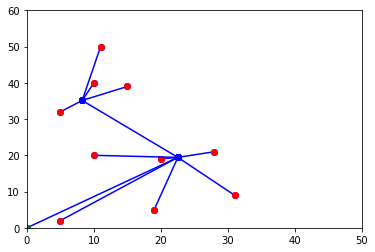

obj : 146.4654523902351
case 4 : 


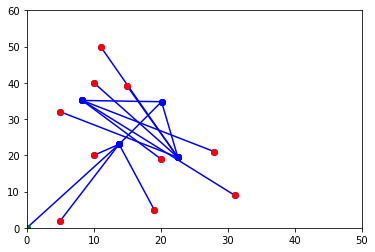

obj : 135.95776668780096
case 5 : 


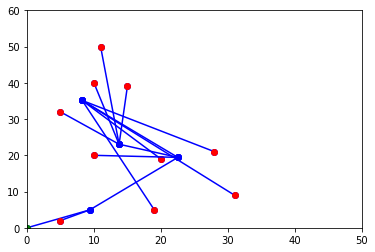

obj : 134.74838077866633
case 6 : 


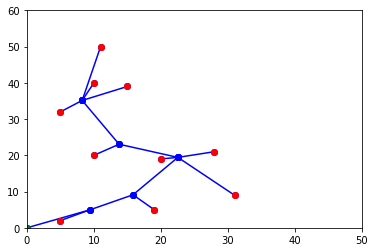

obj : 122.93964215225718


In [24]:
# 畫圖方便觀察用
for i in best_it:
    print('case ' + str(i) + ' : ')
    A1, A2, A3 = init(test_p, best_it[i], test_goal)
    test_model = setup(test_p, best_it[i], A1,A2,A3,test_goal)
    test_model.Params.LogToConsole = 0
    test_model.optimize()
    fig = plt.figure()
    # plt.xlim(-5,map_range[0]+5)
    # plt.ylim(-5,map_range[1]+5)
    candi = bestcase[0]
    goal = test_goal
    p = test_p
    x1 = []
    x2 = []
    x3 = []
    for v in test_model.getVars():
        if(v.x > 0):
            if("x1" in v.VarName):
                x1.append(v.VarName.replace("x1","").replace("(","").replace(")","").split(",")) 
            if("x2" in v.VarName):
                x2.append(v.VarName.replace("x2","").replace("(","").replace(")","").split(","))
            if("x3" in v.VarName):
                x3.append(v.VarName.replace("x3","").replace("(","").replace(")",""))

    for i in range(len(x3)):
        plt.plot([candi[int(x3[i])][0],goal[0]],[candi[int(x3[i])][1],goal[1]],'bo-')
    for i in range(len(x2)):
        plt.plot([candi[int(x2[i][0])][0],candi[int(x2[i][1])][0]],[candi[int(x2[i][0])][1],candi[int(x2[i][1])][1]],'bo-')
    for i in range(len(x1)):
        plt.plot([p[int(x1[i][0])][0],candi[int(x1[i][1])][0]],[p[int(x1[i][0])][1],candi[int(x1[i][1])][1]],'bo-')
        plt.plot(p[i][0],p[i][1],'ro')
    plt.plot(goal[0],goal[1],'go')
    plt.axis([0,50,0,60])
    plt.show()
    print('obj : ' + str(test_model.ObjVal))

In [18]:
save_best = best
save_obj = bestObj

In [19]:
# def clearFile(filename):
#     open(filename, 'w').close()

In [20]:
# path = {}
# for i in range(len(test_p)):
#     path[i] = [i]
# for i, j in x1:
#     path[int(i)].append(int(j) + len(test_p))
# for i , j in x2:
#     for k in path:
#         if path[k][len(path[k]) - 1] == int(i) + len(test_p):
#             path[k].append(int(j) + len(test_p))
# for i in x3:
#     for k in path:
#         if path[k][len(path[k]) - 1] == int(i) + len(test_p):
#             path[k].append('end')

In [21]:
# filename = 'input_point.txt'
# f = open(filename, "a")
# clearFile(filename)
# f.write('n\t' + str(len(test_p)) + '\t\n')
# f.write('m\t' + str(len(bestcase[0])) + '\t\n')
# f.write('s\t' + str(test_goal[0]) + '\t' + str(test_goal[1]) + '\t\n')
# for i in test_p:
#     f.write('d\t' + str(i) + '\t' + str(test_p[i][0]) + '\t' + str(test_p[i][1]) + '\t\n')
# for i in path:
#     f.write('p')
#     for j in path[i]:
#         if j == 'end':
#             f.write('\t-1')
#         else:
#             f.write('\t' + str(j))
#     f.write('\n')
        
        
# f.write('e')
# f.close()